<a href="https://colab.research.google.com/github/Pillangocska/Machine_Learning_VIMIMA05/blob/main/6_Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aktív tanulás

A félkarú rabló mintájára legyen adott $K$-karú játékgép, ahol, ha szerencsénk van, egy kart meghúzva valamekkora jutalomban (*reward*) részesülhetünk. Az egyes karok által adott jutalmak valószínűségi változók, amelyek ismeretlen, egymástól független eloszlásokat követnek. A célunk, hogy a karok egymás után történő húzogatásával
- Felfedezzük a problémateret, azaz megbecsüljük az egyes karok "jóságát" (*exploration*),
- Ezt a tudást kihasználva maximalizáljuk az összes jutalmunkat (*exploitation*).

Érezzük, hogy a két cél egymásnak ellentmond: a felfedezéshez szuboptimális karokat is meg kell húznunk, ezzel azonban az összes jutalmunkat csökkentjük. A karok valószínűségi természete miatt az is előfordulhat, hogy egy-egy "jó" kar éppen rossz jutalmat ad, így érdemes lehet a pillanatnyilag rossznak gondolt karokat is többször tesztelni. Ez az *exploration vs. exploitation* dilemma.

Bár az általunk vizsgált stratégiák többféle eloszlás esetében is működnek, mi a már jól ismert Bernoulli-eloszlást fogjuk használni. Azaz minden karhoz tartozik egy ismeretlen $\theta_k$ paraméter, egy húzás pedig egy Bernoulli-kísérletnek felel meg:

\begin{align}
p\left(y \mid \theta_k \right) = \mathcal{B}ern \left(y \mid \theta_k \right) = \theta_k^{y} (1-\theta_k)^{1-y},
\end{align}

ahol $y \in \left\lbrace 0,1 \right\rbrace$ a $k$. kar meghúzása után kapott jutalom. A továbbiakban jelölje $\bar y_k$ a $k.$ kar által adott jutalmak átlagát, $n_k$ azt, hogy hányszor húztuk meg a $k$. kart, $n$ pedig az összes húzások számát egészen mostanáig.

Egy stratégia fontos jellemzője a megbánás (*regret*), ami a mi esetünkben a következőképpen definiálható:

\begin{align}
\sum_{k=1}^K n_k \left(\theta^* - \theta_k \right),
\end{align}

ahol $\theta^*$ a legjobb kar jutalmának várható értéke, $\theta_k$ pedig a $k$. karé (ami most, Bernoulli-eloszlásról lévén szó, megegyezik a paraméterrel). Azaz itt valójában azt mérjük, hogy várhatóan mennyit veszítünk amiatt, hogy a stratégiánk nem mindig a legjobb kart választja.

## Stratégiák

A következő stratégiákat fogjuk implementálni:

- $\varepsilon$-greedy: adott $\varepsilon$ valószínűséggel felfedezünk, azaz véletlenszerűen válaszott kart húzunk meg; különben azt, amelyik eddig átlagosan a legnagyobb kifizetést adta (azaz $\bar y_k$ maximális).
- UCB1: először minden kart meghúzunk egyszer, majd mindig azt húzzuk, amelyik a $\bar y_k + \sqrt{\frac{2 \ln n}{n_k}}$ mennyiséget maximalizálja.
- UCB-$\alpha$: hasonlóan az előbbihez, de $\bar y_k + \sqrt{\frac{\alpha \ln n}{n_k}}$-t használunk.
- Thompson-mintavétel: minden karra felteszünk egy $\beta$ prior eloszlást, majd mintát veszünk és a maximálisat választjuk; a jutalom ismeretében a $\beta$-eloszlás frissítése a már ismert módon történik (konjugált eloszlások, tavalyi első labor).
- Bayesi UCB: hasonlóképpen fenntartunk egy $\beta$-eloszlást, de a választásnál nem mintát veszünk, hanem $1- \frac{1}{1+n}$ percentilist veszünk alapul (pl. a `beta.ppf()` függvénnyel).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import beta


In [2]:
# Prototype agent example
class Agent:
  def __init__(self,K):
    self.X = [] # rewards so far
    self.A = [] # which lever we pulled
    self.K = K  # number of arms

  # Mandatory: which should be the next arm
  def get_arm(self):
    self.arm = np.random.choice(self.K)
    return self.arm

  # Required: update agent status
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]


**1. feladat.** Valósítsa meg az ágenseket a prototípus alapján! Az ágenseknek a `get_arm()` és az `update()` függvényeket kötelező implementálniuk.

In [19]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, K, epsilon=0.1):
        super().__init__(K)
        self.epsilon = epsilon
        self.counts = [0] * K
        self.values = [0.0] * K

    def get_arm(self):
        if np.random.random() < self.epsilon:
            self.arm = np.random.choice(self.K)
        else:
            self.arm = np.argmax(self.values)
        return self.arm

    def update(self, reward):
        self.counts[self.arm] += 1
        n = self.counts[self.arm]
        value = self.values[self.arm]
        self.values[self.arm] = ((n - 1) / n) * value + (1 / n) * reward
        super().update(reward)

class UCB1Agent(Agent):
    def __init__(self, K):
        super().__init__(K)
        self.counts = [0] * K
        self.values = [0.0] * K
        self.total_count = 0

    def get_arm(self):
        if 0 in self.counts:
            self.arm = self.counts.index(0)
        else:
            ucb_values = [self.values[i] + np.sqrt((2 * np.log(self.total_count)) / self.counts[i]) for i in range(self.K)]
            self.arm = np.argmax(ucb_values)
        return self.arm

    def update(self, reward):
        self.counts[self.arm] += 1
        self.total_count += 1
        n = self.counts[self.arm]
        value = self.values[self.arm]
        self.values[self.arm] = ((n - 1) / n) * value + (1 / n) * reward
        super().update(reward)

class UCBAlphaAgent(UCB1Agent):
    def __init__(self, K, alpha=2):
        super().__init__(K)
        self.alpha = alpha

    def get_arm(self):
        if 0 in self.counts:
            self.arm = self.counts.index(0)
        else:
            ucb_values = [self.values[i] + np.sqrt((self.alpha * np.log(self.total_count)) / self.counts[i]) for i in range(self.K)]
            self.arm = np.argmax(ucb_values)
        return self.arm

class ThompsonSamplingAgent(Agent):
    def __init__(self, K):
        super().__init__(K)
        self.successes = [1] * K
        self.failures = [1] * K

    def get_arm(self):
        samples = [beta.rvs(a, b) for a, b in zip(self.successes, self.failures)]
        self.arm = np.argmax(samples)
        return self.arm

    def update(self, reward):
        if reward == 1:
            self.successes[self.arm] += 1
        else:
            self.failures[self.arm] += 1
        super().update(reward)

class BayesianUCBAgent(Agent):
    def __init__(self, K):
        super().__init__(K)
        self.successes = [1] * K
        self.failures = [1] * K
        self.total_count = 0

    def get_arm(self):
        quantiles = [beta.ppf(1 - 1 / (1 + self.total_count), a, b) for a, b in zip(self.successes, self.failures)]
        self.arm = np.argmax(quantiles)
        return self.arm

    def update(self, reward):
        if reward == 1:
            self.successes[self.arm] += 1
        else:
            self.failures[self.arm] += 1
        self.total_count += 1
        super().update(reward)



**2. feladat.** Szimulálja mindegyik ágens választásait az alábbi karoknál!

In [30]:
rewards = [0.01, 0.02, 0.857, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]


In [31]:
# # simulation with T moves
def simulate(rewards,agent,T=10000):
  for t in range(T):
    arm    = agent.get_arm()
    reward = (np.random.rand()<rewards[arm])*1
    agent.update(reward)


In [32]:
agents = {
    'Epsilon-Greedy': EpsilonGreedyAgent(len(rewards), epsilon=0.1),
    'UCB1': UCB1Agent(len(rewards)),
    'UCB-Alpha': UCBAlphaAgent(len(rewards), alpha=2),
    'Thompson Sampling': ThompsonSamplingAgent(len(rewards)),
    'Bayesian UCB': BayesianUCBAgent(len(rewards))
}

results = {}
for name, agent in agents.items():
    results[name] = simulate(rewards, agent)


**3. feladat.** Minden ágenshez ábrázolja scatter plot-on, mikor melyik kart húzta meg (vízszintes tengely: húzások, függőleges tengely: karok)! A plotok alapján hasonlítsa össze az ágensek felfedező tevékenységét!

Ügyeljen rá, hogy az eredmények az egyes futásoknál eltérhetnek, így célszerű többször is lefuttatni a méréseket. Különösen az $\varepsilon$-greedy stratégia mutat nagy variabilitást; magyarázza meg, hogy miért!

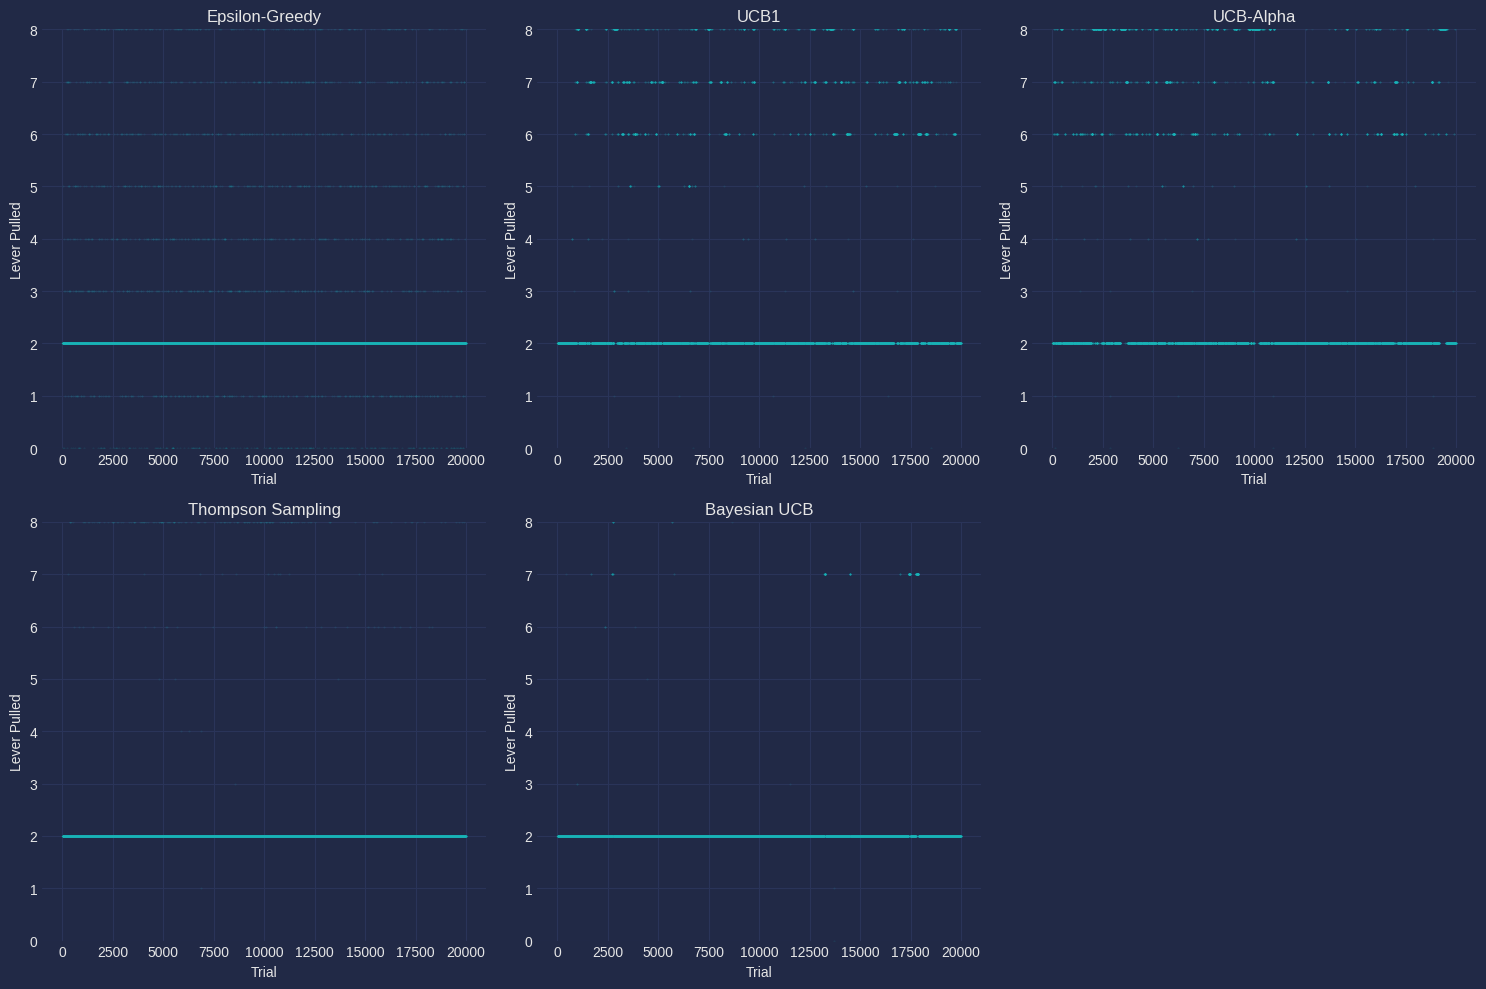

In [33]:
import matplotlib.pyplot as plt

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

def simulate_and_plot(rewards, agent, T=10000):
    levers_pulled = []
    for t in range(T):
        arm = agent.get_arm()
        reward = (np.random.rand() < rewards[arm]) * 1
        agent.update(reward)
        levers_pulled.append(arm)
    return levers_pulled

plt.figure(figsize=(15, 10))
for idx, (name, agent) in enumerate(agents.items(), 1):
    levers_pulled = simulate_and_plot(rewards, agent, T)
    plt.subplot(2, 3, idx)
    plt.scatter(range(T), levers_pulled, alpha=0.1, marker='.', s=1)
    plt.title(name)
    plt.xlabel('Trial')
    plt.ylabel('Lever Pulled')
    plt.ylim(0, len(rewards) - 1)
    plt.yticks(range(len(rewards)))

plt.tight_layout()
plt.show()


**ε-greedy variabilitás**: Véletlenszerűen kutat ε valószínűséggel, és egyébként a "legismertebb"
lehetőséget választja. A scatter plot sok random választást fog mutatni, az exploration factora miatt. A variabilitása azért nagy mert minden próbálkozás során random fog választani, ami miatt a teljesítménye is változik minden futtatással.

**4. feladat.** Értékelje ki és hasonlítsa össze az ágensek teljesítményét! A következőket vegye alapul:

- Átlagos jutalom
- A legjobb kar meghúzásának relatív frekvenciája
- Regret

Az eredményeket az idő (húzások) függvényében is ábrázolja (azaz az ágens tároljon el minden ehhez szükséges információt)! Miben különbözik az $\varepsilon$-greedy ágens regret-je a többi módszerétől?

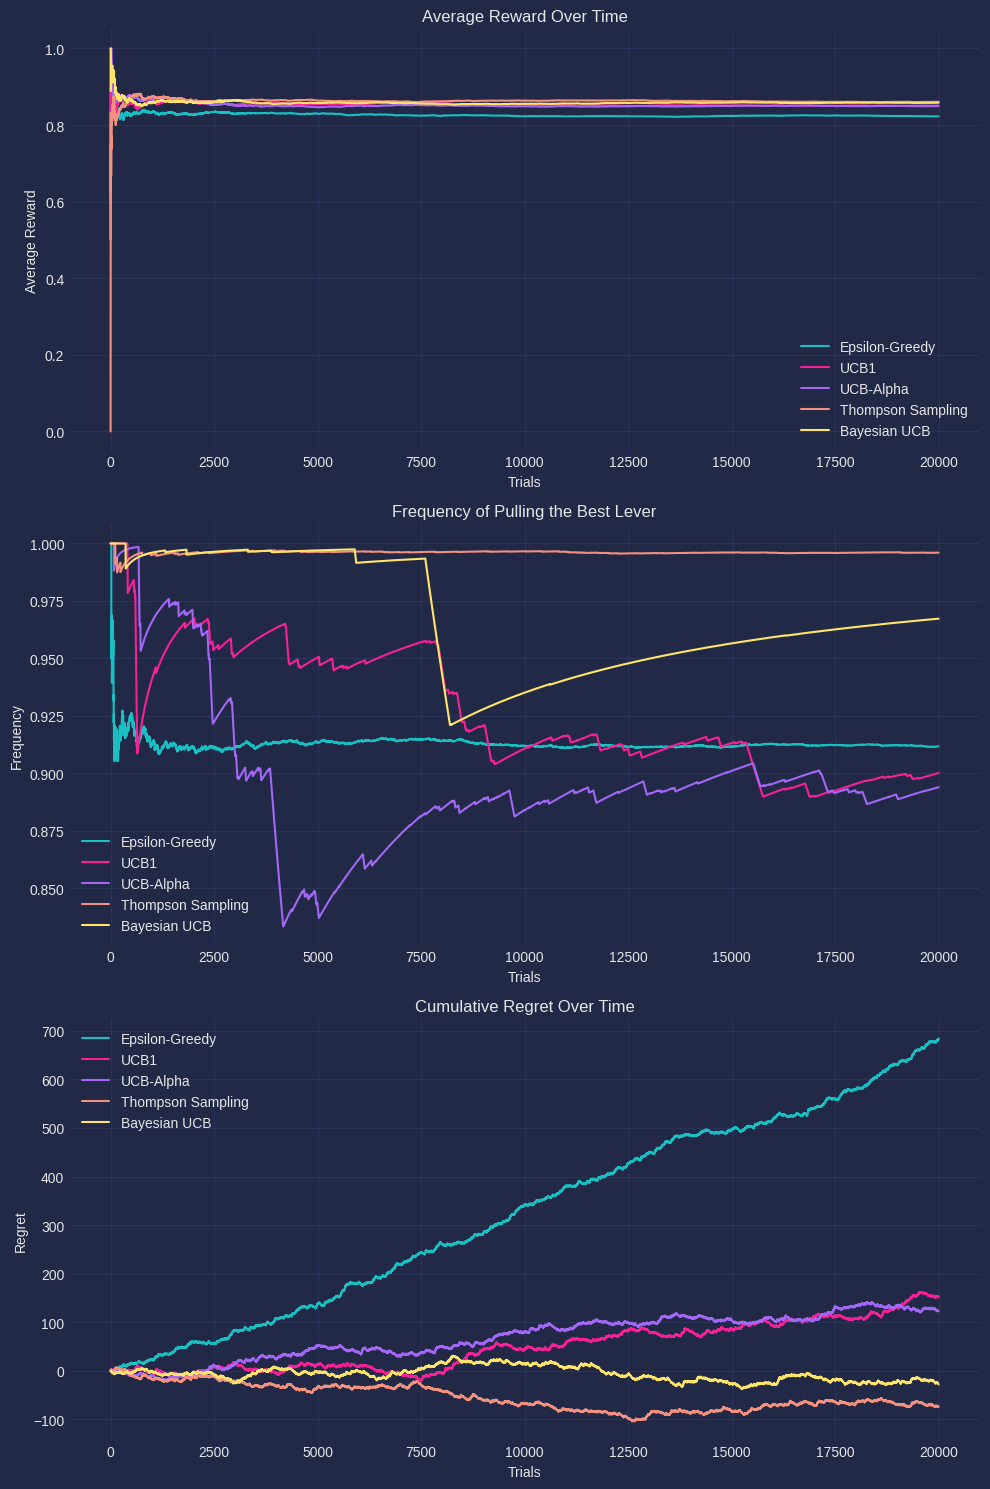

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_with_metrics(rewards, agent, T=10000):
    total_reward = 0
    best_lever = np.argmax(rewards)
    best_lever_count = 0
    rewards_history = []
    best_lever_pulls = []
    regrets = []

    for t in range(1, T+1):
        arm = agent.get_arm()
        reward = (np.random.rand() < rewards[arm]) * 1
        agent.update(reward)

        # update metrics
        total_reward += reward
        rewards_history.append(reward)
        if arm == best_lever:
            best_lever_count += 1

        best_lever_pulls.append(best_lever_count / t)
        optimal_reward = rewards[best_lever] * t
        regrets.append(optimal_reward - total_reward)

    average_rewards = np.cumsum(rewards_history) / np.arange(1, T+1)
    return average_rewards, best_lever_pulls, regrets

# simulation and plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
results = {}

for name, agent in agents.items():
    avg_rewards, freq_best_lever, cumulative_regret = simulate_with_metrics(rewards, agent, T)
    results[name] = (avg_rewards, freq_best_lever, cumulative_regret)
    axes[0].plot(avg_rewards, label=name)
    axes[1].plot(freq_best_lever, label=name)
    axes[2].plot(cumulative_regret, label=name)

axes[0].set_title('Average Reward Over Time')
axes[0].set_xlabel('Trials')
axes[0].set_ylabel('Average Reward')

axes[1].set_title('Frequency of Pulling the Best Lever')
axes[1].set_xlabel('Trials')
axes[1].set_ylabel('Frequency')

axes[2].set_title('Cumulative Regret Over Time')
axes[2].set_xlabel('Trials')
axes[2].set_ylabel('Regret')

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


**Miben különbözik az  ε -greedy ágens regret-je a többi módszerétől?**
A regret-je általában nagyobb, az adaptív stratégiákhoz képest, mint az UCB vagy a Thompson, a rögzített ϵ miatt. A szimuláció előrehaladtával és az optimális cselekvés világosabbá válásával is állandó sebességgel folytatja a kevésbé optimális választások feltárását, ami idővel fokozott megbánáshoz vezet, ellentétben az adaptív stratégiákkal, amik a tanulás során inkább a "exploitation"-re összpontosítanak.

**5. feladat.** Tetszőleges problémában ábrázolja a Thompson ágens
$\beta$-posteriorjait a tanítás legvégén! Mit lehet megfigyelni? Miért mondhatjuk, hogy ez egy "optimista" stratégia?

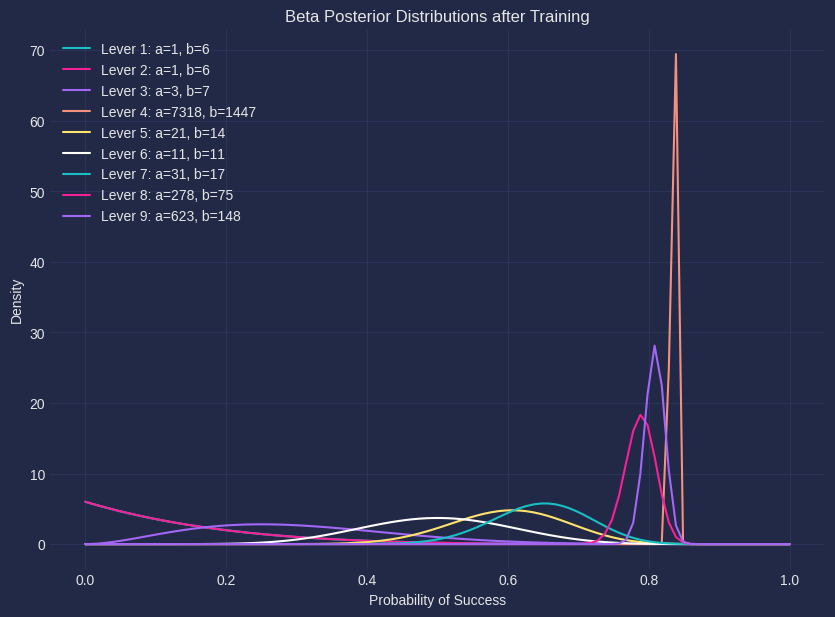

In [38]:
rewards = [0.01, 0.02, 0.3, 0.841, 0.5, 0.6, 0.795, 0.8, 0.805]
agent = ThompsonSamplingAgent(len(rewards))
T = 10000

for t in range(T):
    arm = agent.get_arm()
    reward = (np.random.rand() < rewards[arm]) * 1
    agent.update(reward)

# plotting for each arm
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(len(rewards)):
    a = agent.successes[i]
    b = agent.failures[i]
    y = beta.pdf(x, a, b)
    ax.plot(x, y, label=f'Lever {i+1}: a={a}, b={b}')

ax.set_title('Beta Posterior Distributions after Training')
ax.set_xlabel('Probability of Success')
ax.set_ylabel('Density')
ax.legend()

plt.show()


**Mit lehet megfigyelni? Miért mondhatjuk, hogy ez egy "optimista" stratégia?**

A 4,8,9-es karoknak vannak a "legcsúcsosabb" eloszlásaik, ami azt jelenti hogy a modell erősebben hisz ezeknél a karoknál a jutalomban. Ez azt is jelenti hogy több mintavételezés történt ezeknél az értékeknél, tehát biztosabbak vagyunk az eloszlásban.

A Thompson-mintavétel optimista mert mindig a béta eloszlás által legkedvezőbbnek vélt forgatókönyv alapján történik a mintavétel. Az alulkihasznált karokat is feltárja, amelyek a vártnál jobbnak bizonyulhatnak. Ez hosszútávon haszonhoz vezethet mert megakadályozza az algoritmust hogy idő előtt konvergáljon szuboptimális választásokhoz, és olyan környezetekben is hasznos ahol a jutalom dinamikája megváltozhat vagy a kezdeti becslések félrevezetőek lehetnek a korai megfigyelések eltérései miatt.